In [1]:
# Imports and setup
import pandas as pd
import numpy as np
import os
import re
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Standard column names
standard_columns = [
    'Site_Id', 'Date', 'Time', 'PREC', 'TOBS', 'TMAX', 'TMIN', 'TAVG', 'PRCP',
    'SMS_2', 'SMS_4', 'SMS_8', 'SMS_12', 'SMS_20', 'SMS_40', 'SMS_60', 'SMS_80',
    'STO_2', 'STO_4', 'STO_8', 'STO_12', 'STO_20', 'STO_40', 'STO_60', 'STO_80',
    'STO2_2', 'STO2_4', 'STO2_8', 'STO2_12', 'STO2_20', 'STO2_40', 'STO2_60', 'STO2_80',
    'RHUM'
]

# Updated header mapping
header_mapping = {
    'Site Id': 'Site_Id',
    'Date': 'Date',
    'Time': 'Time',
    'PREC.I-1 (in)': 'PREC',
    'TOBS.I-1 (degC)': 'TOBS',
    'TMAX.D-1 (degC)': 'TMAX',
    'TMIN.D-1 (degC)': 'TMIN',
    'TAVG.D-1 (degC)': 'TAVG',
    'PRCP.D-1 (in)': 'PRCP',
    'SMS.I-1:-2 (pct)  (loam)': 'SMS_2',
    'SMS.I-1:-4 (pct)  (loam)': 'SMS_4',
    'SMS.I-1:-8 (pct)  (loam)': 'SMS_8',
    'SMS.I-1:-12 (pct)  (loam)': 'SMS_12',
    'SMS.I-1:-20 (pct)  (loam)': 'SMS_20',
    'SMS.I-1:-40 (pct)  (loam)': 'SMS_40',
    'SMS.I-1:-60 (pct)  (loam)': 'SMS_60',
    'SMS.I-1:-80 (pct)  (loam)': 'SMS_80',
    'STO.I-1:-2 (degC)': 'STO_2',
    'STO.I-1:-4 (degC)': 'STO_4',
    'STO.I-1:-8 (degC)': 'STO_8',
    'STO.I-1:-12 (degC)': 'STO_12',
    'STO.I-1:-20 (degC)': 'STO_20',
    'STO.I-1:-40 (degC)': 'STO_40',
    'STO.I-1:-60 (degC)': 'STO_60',
    'STO.I-1:-80 (degC)': 'STO_80',
    'STO.I-2:-2 (degC)': 'STO2_2',
    'STO.I-2:-4 (degC)': 'STO2_4',
    'STO.I-2:-8 (degC)': 'STO2_8',
    'STO.I-2:-12 (degC)': 'STO2_12',
    'STO.I-2:-20 (degC)': 'STO2_20',
    'STO.I-2:-40 (degC)': 'STO2_40',
    'STO.I-2:-60 (degC)': 'STO2_60',
    'STO.I-2:-80 (degC)': 'STO2_80',
    'RHUM.I-1 (pct)': 'RHUM'
}

# Directory and file pattern
scan_data_dir = 'scan_data_2108'
files = glob(os.path.join(scan_data_dir, '2108_SCAN_YEAR=*.csv'))

# Check directory existence
if not os.path.exists(scan_data_dir):
    raise ValueError(f"Directory {scan_data_dir} does not exist.")

# Load and process CSV files
df_list = []
for file in files:
    try:
        # Read headers explicitly to debug
        with open(file, 'r') as f:
            headers = f.readlines()[6].strip().split(',')
        print(f"\nRaw headers in {file}: {headers}")

        df = pd.read_csv(file, skiprows=6, na_values=['', 'NaN', -99.9, '-99.9', 'N/A', 'missing'])
        if df.empty:
            print(f"Skipping empty file: {file}")
            continue
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

    # Drop unnamed columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed', na=False)]

    # Map headers
    mapped_columns = []
    unmapped_columns = []
    for col in df.columns:
        # Normalize column name: remove extra spaces, normalize case
        cleaned_col = re.sub(r'\s+', ' ', col.strip())
        mapped_col = header_mapping.get(cleaned_col, None)
        
        # Fallback for SMS columns
        if not mapped_col and 'SMS.I-1:-' in cleaned_col:
            depth = re.search(r'SMS.I-1:-(\d+)', cleaned_col)
            if depth:
                mapped_col = f'SMS_{depth.group(1)}'
        
        if mapped_col:
            mapped_columns.append(mapped_col)
        else:
            mapped_columns.append(col)
            unmapped_columns.append(col)

    if unmapped_columns:
        print(f"Unmapped headers in {file}: {unmapped_columns}")

    df.columns = mapped_columns

    # Handle empty Time column
    df['Time'] = df['Time'].fillna('00:00')
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M', errors='coerce')
    df = df.dropna(subset=['Datetime'])

    df_list.append(df)

# Concatenate non-empty DataFrames
if not df_list:
    raise ValueError("No valid CSV files found.")
df = pd.concat([df for df in df_list if not df.empty], ignore_index=True)

# Filter invalid dates
valid_date_pattern = re.compile(r'^\d{4}-\d{2}-\d{2}$')
df = df[df['Date'].str.match(valid_date_pattern, na=False)]

# Drop rows with NaT Datetime
df = df.dropna(subset=['Datetime'])

# Check for duplicates
if df['Datetime'].duplicated().any():
    print("Dropping duplicate Datetime entries...")
    df = df.drop_duplicates(subset=['Datetime'], keep='first')

# Set Datetime as index
df = df.set_index('Datetime')
df = df.drop(['Date', 'Time'], axis=1, errors='ignore')

# Convert to numeric and replace invalid values
df = df.replace([-99.9, '-99.9', 'N/A', 'missing'], np.nan)
numeric_cols = [col for col in df.columns if col not in ['Site_Id']]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Keep only standard columns
df = df[[col for col in df.columns if col in standard_columns]]

# Summary output for available columns
summary_cols = ['PREC', 'TOBS', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'SMS_2', 'RHUM']
available_cols = [col for col in summary_cols if col in df.columns]
print("\nDataset Summary:")
print(df[available_cols].describe())
print("\nNaN counts for key columns:")
print(df[available_cols].isna().sum())


Raw headers in scan_data_2108\2108_SCAN_YEAR=2005.csv: ['Site Id', 'Date', 'Time', 'PREC.I-1 (in) ', 'TOBS.I-1 (degC) ', 'TMAX.D-1 (degC) ', 'TMIN.D-1 (degC) ', 'TAVG.D-1 (degC) ', 'PRCP.D-1 (in) ', 'SMS.I-1:-2 (pct)  (loam)', 'SMS.I-1:-4 (pct)  (loam)', 'SMS.I-1:-8 (pct)  (loam)', 'SMS.I-1:-12 (pct)  (loam)', 'SMS.I-1:-20 (pct)  (loam)', 'SMS.I-1:-40 (pct)  (loam)', 'SMS.I-1:-60 (pct)  (loam)', 'SMS.I-1:-80 (pct)  (loam)', 'STO.I-1:-2 (degC) ', 'STO.I-1:-4 (degC) ', 'STO.I-1:-8 (degC) ', 'STO.I-1:-12 (degC) ', 'STO.I-1:-20 (degC) ', 'STO.I-1:-40 (degC) ', 'STO.I-1:-60 (degC) ', 'STO.I-1:-80 (degC) ', 'STO.I-2:-2 (degC) ', 'STO.I-2:-4 (degC) ', 'STO.I-2:-8 (degC) ', 'STO.I-2:-12 (degC) ', 'STO.I-2:-20 (degC) ', 'STO.I-2:-40 (degC) ', 'STO.I-2:-60 (degC) ', 'STO.I-2:-80 (degC) ', '']

Raw headers in scan_data_2108\2108_SCAN_YEAR=2006.csv: ['Site Id', 'Date', 'Time', 'PREC.I-1 (in) ', 'TOBS.I-1 (degC) ', 'TMAX.D-1 (degC) ', 'TMIN.D-1 (degC) ', 'TAVG.D-1 (degC) ', 'PRCP.D-1 (in) ', 'SMS.


Displaying: Monthly Average Air Temperature by Year


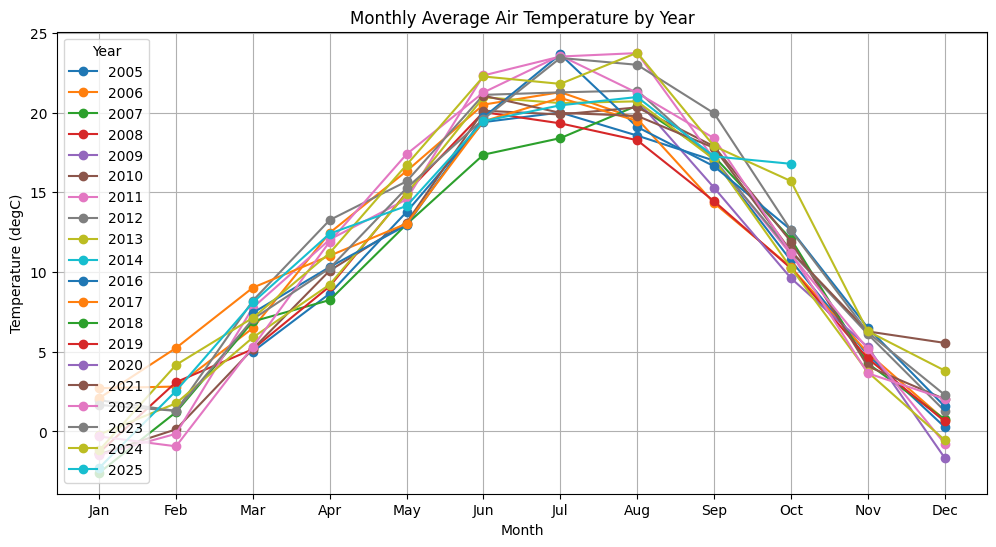

In [2]:
# New Plot: Monthly average TOBS for each year
print("\nDisplaying: Monthly Average Air Temperature by Year")
# Group by year and month, compute mean TOBS
df['Year'] = df.index.year
df['Month'] = df.index.month
monthly_avg = df.groupby(['Year', 'Month'])['TOBS'].mean().unstack(level=0)
# Plot each year as a line
plt.figure(figsize=(12, 6))
for year in monthly_avg.columns:
    plt.plot(monthly_avg.index, monthly_avg[year], label=f'{year}', marker='o')
plt.title('Monthly Average Air Temperature by Year')
plt.xlabel('Month')
plt.ylabel('Temperature (degC)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()
#print("\nMonthly Average TOBS by Year:")
#print(monthly_avg)


Displaying: Daily Average Air Temperature by Year


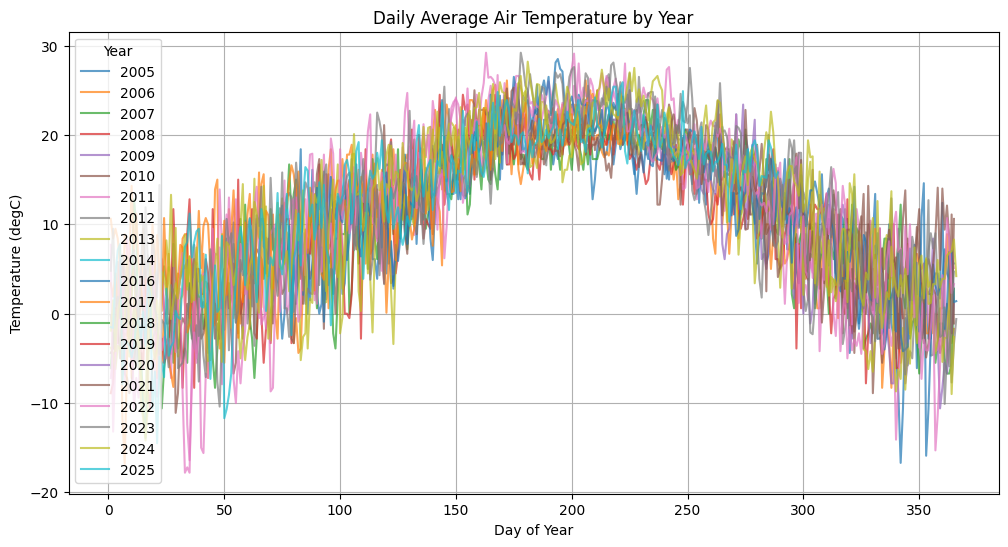

In [3]:
# New Plot: Daily average TOBS for each year
print("\nDisplaying: Daily Average Air Temperature by Year")
df['DayOfYear'] = df.index.dayofyear
daily_avg = df.groupby(['Year', 'DayOfYear'])['TOBS'].mean().unstack(level=0)
plt.figure(figsize=(12, 6))
for year in daily_avg.columns:
    plt.plot(daily_avg.index, daily_avg[year], label=f'{year}', alpha=0.7)
plt.title('Daily Average Air Temperature by Year')
plt.xlabel('Day of Year')
plt.ylabel('Temperature (degC)')
plt.legend(title='Year')
plt.grid(True)
plt.show()


Displaying: Monthly Average Soil Temperature at 4cm by Year


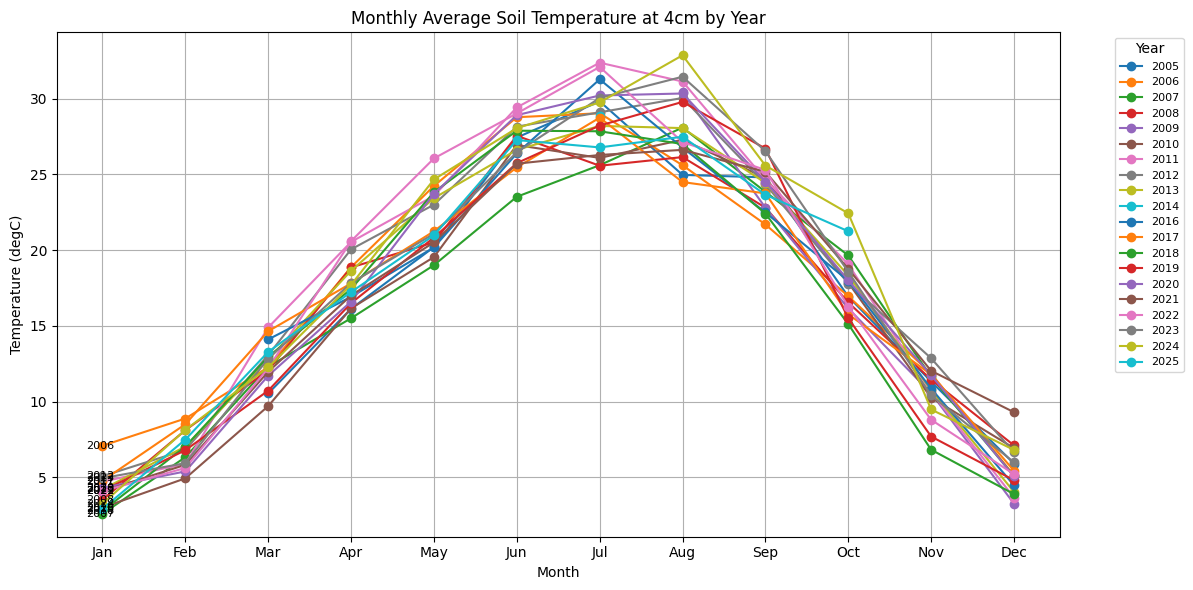

In [4]:
# New Plot: Monthly average STO_4 for each year
if 'STO_4' in df.columns:
    print("\nDisplaying: Monthly Average Soil Temperature at 4cm by Year")
    # Group by year and month, compute mean STO_4
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    monthly_avg = df.groupby(['Year', 'Month'])['STO_4'].mean().unstack(level=0)
    # Plot each year as a line with year labels at start
    plt.figure(figsize=(12, 6))
    for year in monthly_avg.columns:
        plt.plot(monthly_avg.index, monthly_avg[year], label=f'{year}', marker='o')
        # Add year label at Month 1 (January)
        if not np.isnan(monthly_avg[year].loc[1]):  # Check if January data exists
            plt.text(0.8, monthly_avg[year].loc[1], str(year), fontsize=8, verticalalignment='center')
    plt.title('Monthly Average Soil Temperature at 4cm by Year')
    plt.xlabel('Month')
    plt.ylabel('Temperature (degC)')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend(title='Year', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\nWarning: STO_4 column (soil temperature at 4cm) not available in the dataset. Check if the CSV files include STO.I-1:-4 (degC) or similar.")



Displaying: Annual Average Air Temperature


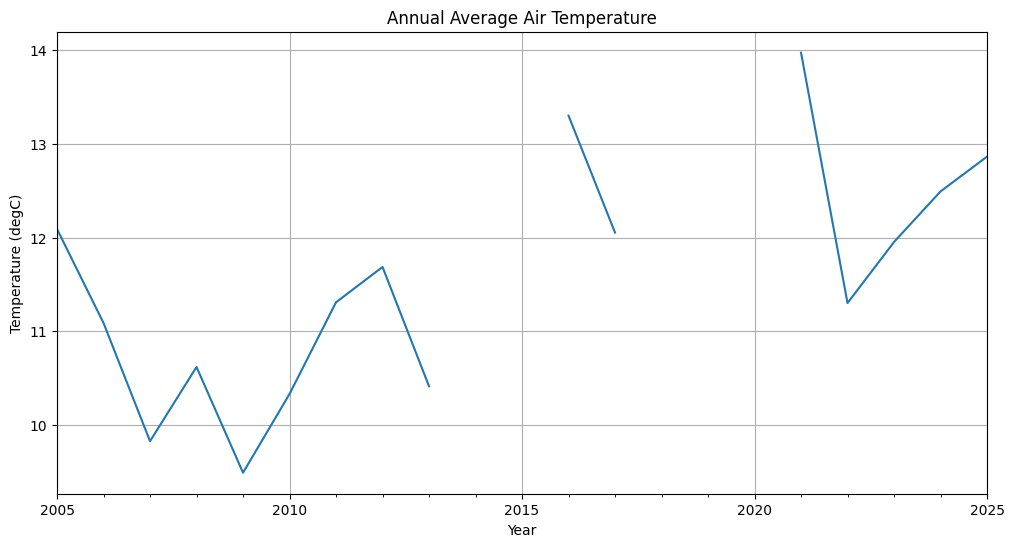

In [5]:
# 1. Long-term trend: Annual average air temperature (TOBS) to check for warming
print("\nDisplaying: Annual Average Air Temperature")
annual_avg = df['TOBS'].resample('YE').mean()  # Year-end resampling
plt.figure(figsize=(12, 6))
annual_avg.plot(title='Annual Average Air Temperature')
plt.ylabel('Temperature (degC)')
plt.xlabel('Year')
plt.grid(True)
plt.show()


Displaying: Seasonal Air Temperature Patterns


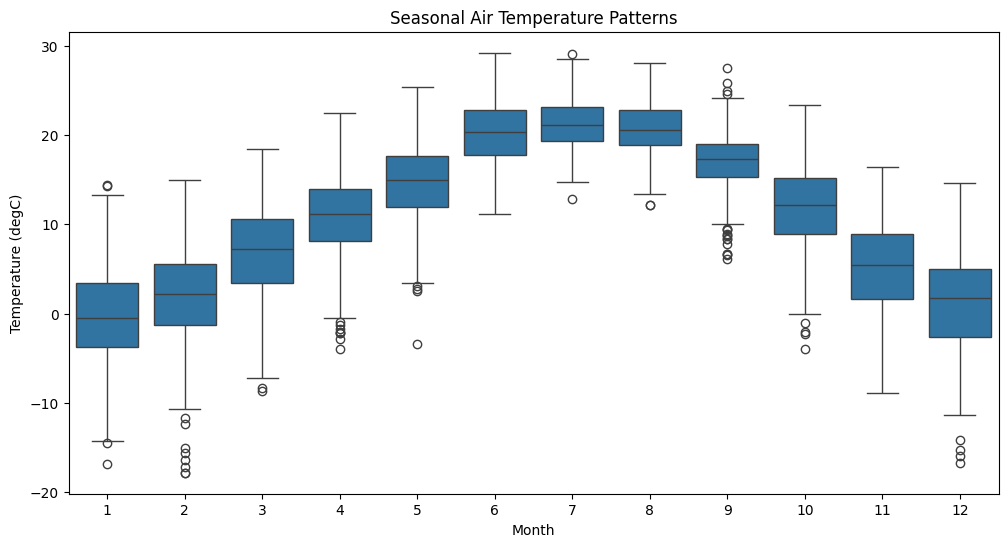


Displaying: Seasonal Precipitation Patterns


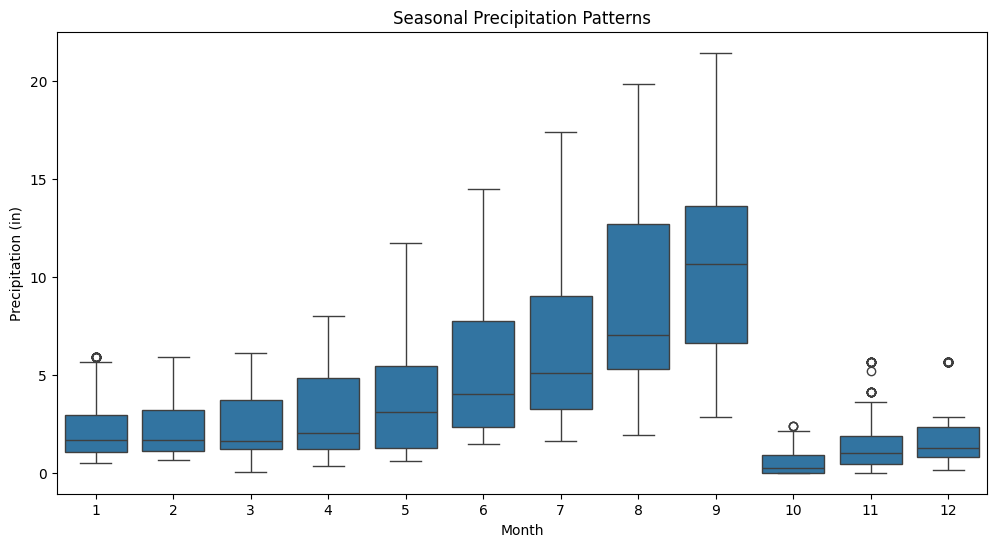

In [6]:
# 2. Seasonal patterns: Monthly boxplots for key variables
df['Month'] = df.index.month
print("\nDisplaying: Seasonal Air Temperature Patterns")
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='TOBS', data=df)
plt.title('Seasonal Air Temperature Patterns')
plt.ylabel('Temperature (degC)')
plt.show()

print("\nDisplaying: Seasonal Precipitation Patterns")
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='PREC', data=df)
plt.title('Seasonal Precipitation Patterns')
plt.ylabel('Precipitation (in)')
plt.show()

#print("\nDisplaying: Seasonal Solar Radiation Patterns")
#plt.figure(figsize=(12, 6))
#sns.boxplot(x='Month', y='SRAD', data=df)
#plt.title('Seasonal Solar Radiation Patterns')
#plt.ylabel('Solar Radiation (W/m²)')
#plt.show()
#


In [7]:
## 3. Correlations: Between air temp, soil temps, and other variables
#print("\nDisplaying: Correlation Matrix")
#corr_matrix = df[['TOBS', 'STO_2', 'STO_4', 'STO_8', 'STO_20', 'STO_40', 'STO_80', 'SRAD', 'PREC']].corr()
#plt.figure(figsize=(10, 8))
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
#plt.title('Correlation Matrix')
#plt.show()
#print("\nKey Correlations (TOBS with other variables):")
#print(corr_matrix['TOBS'].sort_values(ascending=False))




Displaying: Annual Precipitation Totals


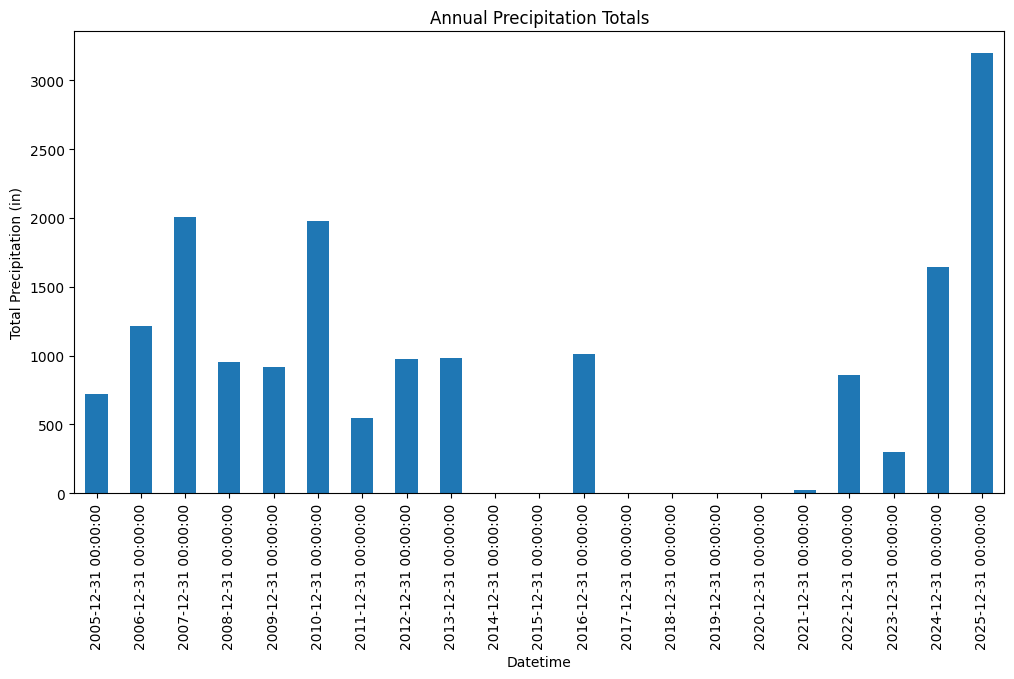

In [8]:
# 4. Yearly precipitation totals
print("\nDisplaying: Annual Precipitation Totals")
annual_precip = df['PREC'].resample('YE').sum()  # Year-end resampling
plt.figure(figsize=(12, 6))
annual_precip.plot(kind='bar', title='Annual Precipitation Totals')
plt.ylabel('Total Precipitation (in)')
plt.show()




Displaying: 2025 Temperature Profiles: Air vs. Soil Depths (Daily Means)


<Figure size 1200x600 with 0 Axes>

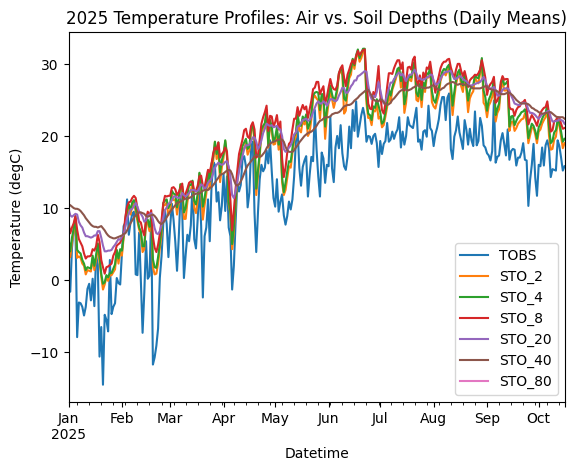

In [9]:
# 5. Soil temperature profiles over depths (last full year in dataset)
last_year = df.index.year.max()
sample_year = df[df.index.year == last_year].resample('D').mean()  # Use boolean mask to select year
if sample_year.empty:
    print(f"\nWarning: No data available for year {last_year}. Skipping soil temperature plot.")
else:
    print(f"\nDisplaying: {last_year} Temperature Profiles: Air vs. Soil Depths (Daily Means)")
    plt.figure(figsize=(12, 6))
    sample_year[['TOBS', 'STO_2', 'STO_4', 'STO_8', 'STO_20', 'STO_40', 'STO_80']].plot()
    plt.title(f'{last_year} Temperature Profiles: Air vs. Soil Depths (Daily Means)')
    plt.ylabel('Temperature (degC)')
    plt.show()



In [11]:
## 6. Battery voltage stability (monthly means for performance)
#print("\nDisplaying: Battery Voltage Over Time (Monthly Means)")
#plt.figure(figsize=(12, 6))
#df['BATT'].resample('M').mean().plot(title='Battery Voltage Over Time (Monthly Means)')
#plt.ylabel('Voltage (V)')
#plt.show()